# News Classifier

### Импорт библиотек

In [30]:
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BAR"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import random
import pymorphy3

from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Загрузка датасета и EDA

In [48]:
data_dir = Path("data")
file_name = "all_news_2025-12-23.csv"
file_path = data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['Publication Date'])
topics_to_hide = ['Sport', 'Health', 'Travels and tourism', 'Weather'] 
df.loc[df['Topic'].isin(topics_to_hide), 'Topic'] = 'Unknown'
topic_dummies = pd.get_dummies(df['Topic'], prefix='Topic', dtype=int)
df = pd.concat([df, topic_dummies], axis=1)
display(df)

,Website,Title,Author,Publication Date,Link,Picture Link,Category,Topic,Relevance,Topic_Accidents,Topic_Culture,Topic_Economics,Topic_Politics,Topic_Science and tech,Topic_Society,Topic_Unknown
0,RT,Corruption-hit aide still calling shots in Kie...,RT,2025-12-21 09:52:05,https://www.rt.com/russia/629835-corruption-sc...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,NaN,Unknown,2,0,0,0,0,0,0,1
1,RT,Google sued for using AI to snoop on users,RT,2025-11-13 15:33:13,https://www.rt.com/business/627746-google-priv...,https://mf.b37mrtl.ru/files/2025.11/thumbnail/...,Бизнес,Science and tech,1,0,0,0,0,1,0,0
2,RT,Chinese company makes historic rocket debut (V...,RT,2025-12-03 17:11:35,https://www.rt.com/business/628866-chinese-fir...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,Бизнес,Politics,1,0,0,0,1,0,0,0
3,Vedomosti.ru,«Рецепт счастья»: едим дома,Роман Черкасов,2025-08-22 00:01:32,https://www.vedomosti.ru/media/columns/2025/08...,https://cdn.vdmsti.ru/image/2025/6h/1djd7l/nor...,Медиа,Unknown,1,0,0,0,0,0,0,1
4,Vedomosti.ru,Банки занялись мошенниками,Ярослав Сталь,2025-10-20 00:06:33,https://www.vedomosti.ru/opinion/columns/2025/...,https://cdn.vdmsti.ru/image/2025/85/7uvh/norma...,Мнения,Economics,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,Vedomosti.ru,Мамута объяснил разницу между блокировкой и пр...,Ведомости,2025-11-18 14:47:58,https://www.vedomosti.ru/finance/news/2025/11/...,https://cdn.vdmsti.ru/image/2025/8y/vowx8/norm...,Финансы / Банки,Unknown,1,0,0,0,0,0,0,1
3206,RT,Russian general assassinated in Moscow,RT,2025-12-22 07:07:49,https://www.rt.com/russia/629859-russian-gener...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,Россия,Politics,2,0,0,0,1,0,0,0
3207,Vedomosti.ru,«Это была рука Бога»: карьера футбольного гени...,"""Анастасия Винницкая, Юлия Томинова-Ерашова""",2025-10-30 07:33:58,https://www.vedomosti.ru/lifestyle/galleries/2...,https://cdn.vdmsti.ru/image/2025/8d/zv7c6/norm...,Стиль жизни / Спорт,Unknown,1,0,0,0,0,0,0,1
3208,Vedomosti.ru,Путин: у России и Армении есть планы по сотруд...,Ведомости,2025-12-22 17:43:34,https://www.vedomosti.ru/business/news/2025/12...,https://cdn.vdmsti.ru/image/2025/9w/11wgya/nor...,Бизнес / ТЭК,Politics,2,0,0,0,1,0,0,0


После загрузки датасета из него была удалена часть строк, относящихся к теме «Politics», чтобы частично исключить дисбаланс классов

#### Анализ датасета

In [49]:
print("1. Общая информация:")
print("-"*40)
print(df.info())
    
print("\n2. Статистика признаков:")
print("-"*40)
display(df.describe(include='all').T)
    
print("\n3. Пропуски в данных:")
print("-"*40)
missing_data = pd.DataFrame({
    'Количество': df.isnull().sum(),
    'Доля в процентах': (df.isnull().sum() / len(df)) * 100
}).sort_values('Количество', ascending=False)
  
display(missing_data[missing_data['Количество'] > 0])
    
print("\n4. Уникальные значения по признакам:")
print("-"*40)
unique_counts = {}
for col in df.columns:
    unique_counts[col] = df[col].nunique()
unique_df = pd.DataFrame({
    'Колонка': list(unique_counts.keys()),
    'Количество уникальных значений': list(unique_counts.values())
})
display(unique_df)

print("\n5. Статистика по категориям:")
print("-"*40)

print("\n5.1 Распределение по веб-сайтам:")
website_stats = df['Website'].value_counts()
print(f"Всего сайтов: {website_stats.shape[0]}")
display(website_stats)

print("\n5.2 Распределение по темам (Topic):")
topic_stats = df['Topic'].value_counts()
display(topic_stats)

print("\n5.3 Распределение релевантности (Relevance):")
relevance_stats = df['Relevance'].value_counts().sort_index()
display(relevance_stats)

print("\n5.4 Статистика релевантности:")
print(f"Средняя релевантность: {df['Relevance'].mean():.2f}")
print(f"Медианная релевантность: {df['Relevance'].median():.2f}")
print(f"Минимальная релевантность: {df['Relevance'].min()}")
print(f"Максимальная релевантность: {df['Relevance'].max()}")

print("\n5.5 Распределение по категориям (Category):")
category_stats = df['Category'].value_counts().head(15)
display(category_stats)

print("\n6. Временные характеристики:")
print("-"*40)

df['Date'] = df['Publication Date'].dt.date
df['Hour'] = df['Publication Date'].dt.hour
df['DayOfWeek'] = df['Publication Date'].dt.day_name()
df['Month'] = df['Publication Date'].dt.month_name()

print("\n6.1 Количество новостей по дням:")
daily_stats = df['Date'].value_counts().sort_index()
print(f"Период охвата: {daily_stats.index.min()} - {daily_stats.index.max()}")
print(f"Всего дней: {daily_stats.shape[0]}")
print(f"Среднее количество новостей в день: {daily_stats.mean():.1f}")

print("\n7. Статистика заголовков:")
print("-"*40)

df['Title_Length'] = df['Title'].apply(lambda x: len(str(x)))
df['Title_Word_Count'] = df['Title'].apply(lambda x: len(str(x).split()))

print(f"Средняя длина заголовка: {df['Title_Length'].mean():.1f} символов")
print(f"Максимальная длина: {df['Title_Length'].max()} символов")
print(f"Минимальная длина: {df['Title_Length'].min()} символов")
print(f"Среднее количество слов: {df['Title_Word_Count'].mean():.1f}")

1. Общая информация:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Website                 3210 non-null   object        
 1   Title                   3210 non-null   object        
 2   Author                  3076 non-null   object        
 3   Publication Date        3210 non-null   datetime64[ns]
 4   Link                    3210 non-null   object        
 5   Picture Link            2910 non-null   object        
 6   Category                3009 non-null   object        
 7   Topic                   3210 non-null   object        
 8   Relevance               3210 non-null   int64         
 9   Topic_Accidents         3210 non-null   int64         
 10  Topic_Culture           3210 non-null   int64         
 11  Topic_Economics         3210 non-null   int64 

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Website,3210,6,Vedomosti.ru,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,3210,2991,Giving the Nobel Peace Prize to warmongers is ...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,3076,400,Ведомости,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publication Date,3210,NaN,NaN,NaN,2025-10-25 09:06:08.126791168,2023-10-18 01:11:05,2025-10-20 00:26:25.249999872,2025-12-09 19:42:18.500000,2025-12-21 14:59:07,2025-12-23 23:11:51,NaN
Link,3210,2995,https://www.rt.com/news/629894-eu-rob-taxpayer...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Picture Link,2910,2697,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,3009,80,Мнения,385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Topic,3210,7,Politics,1667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance,3210.0,NaN,NaN,NaN,1.536449,1.0,1.0,1.0,2.0,5.0,1.023597
Topic_Accidents,3210.0,NaN,NaN,NaN,0.009346,0.0,0.0,0.0,0.0,1.0,0.096236



3. Пропуски в данных:
----------------------------------------


,Количество,Доля в процентах
Picture Link,300,9.345794
Category,201,6.261682
Author,134,4.174455



4. Уникальные значения по признакам:
----------------------------------------


,Колонка,Количество уникальных значений
0,Website,6
1,Title,2991
2,Author,400
3,Publication Date,2973
4,Link,2995
5,Picture Link,2697
6,Category,80
7,Topic,7
8,Relevance,5
9,Topic_Accidents,2



5. Статистика по категориям:
----------------------------------------

5.1 Распределение по веб-сайтам:
Всего сайтов: 6


Website
Vedomosti.ru    2000
RT               600
Lenta.ru         404
RG               100
TASS              99
Gazeta.ru          7
Name: count, dtype: int64


5.2 Распределение по темам (Topic):


Topic
Politics            1667
Unknown              577
Economics            430
Science and tech     250
Culture              130
Society              126
Accidents             30
Name: count, dtype: int64


5.3 Распределение релевантности (Relevance):


Relevance
1    2326
2     405
3     205
4     189
5      85
Name: count, dtype: int64


5.4 Статистика релевантности:
Средняя релевантность: 1.54
Медианная релевантность: 1.00
Минимальная релевантность: 1
Максимальная релевантность: 5

5.5 Распределение по категориям (Category):


Category
Мнения                                      385
Россия                                      374
Бизнес                                      121
Финансы / Банки                             115
Недвижимость / Коммерческая недвижимость    108
Поп-культура                                100
Новости                                     100
Политика / Международные отношения           87
Политика / Международные новости             82
Недвижимость / Жилая недвижимость            76
Экономика / Макроэкономика и бюджет          76
Менеджмент / Рынок труда                     71
Бизнес / Торговля и услуги                   69
Общество                                     64
Технологии / Интернет и digital              64
Name: count, dtype: int64


6. Временные характеристики:
----------------------------------------

6.1 Количество новостей по дням:
Период охвата: 2023-10-18 - 2025-12-23
Всего дней: 328
Среднее количество новостей в день: 9.8

7. Статистика заголовков:
----------------------------------------
Средняя длина заголовка: 61.5 символов
Максимальная длина: 132 символов
Минимальная длина: 9 символов
Среднее количество слов: 9.0


#### Построение графиков

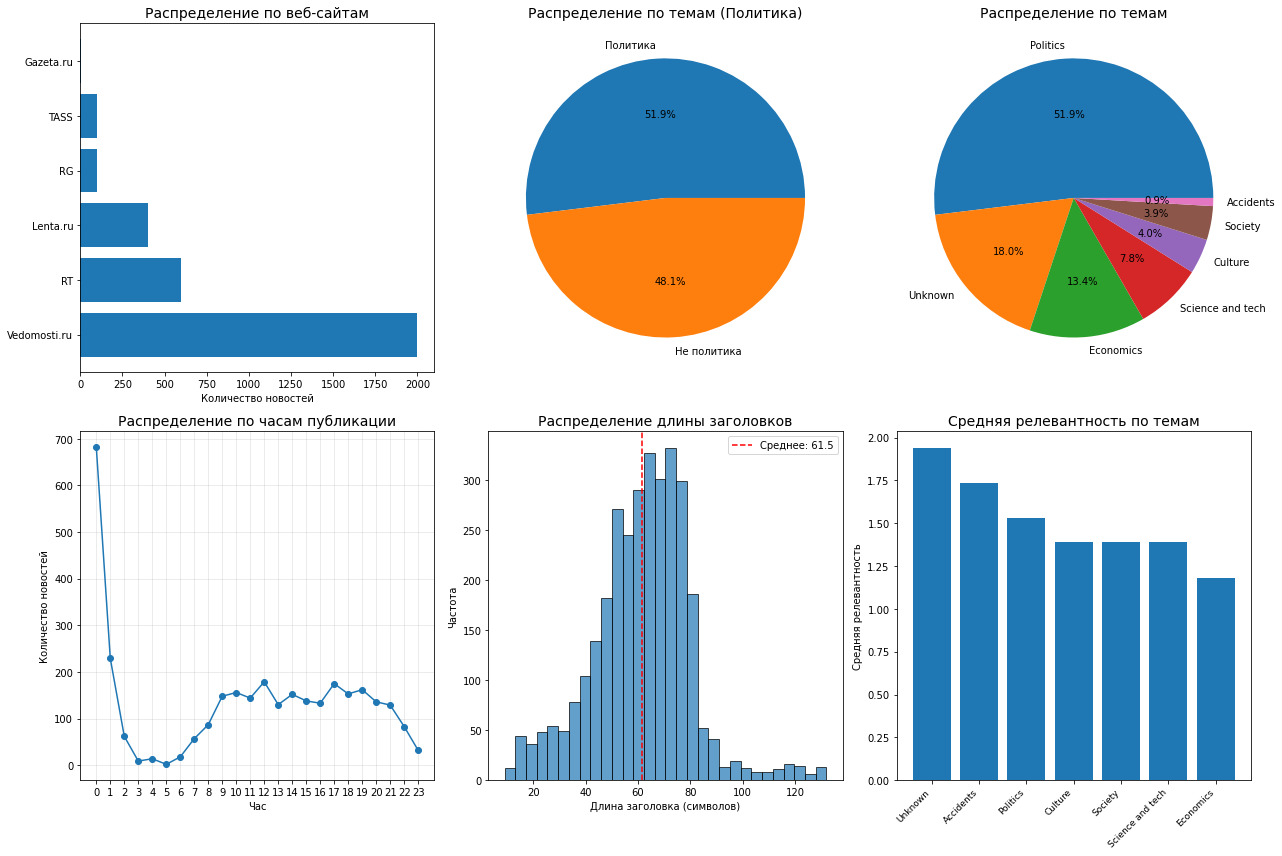

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

top_websites = df['Website'].value_counts()
axes[0, 0].barh(range(len(top_websites)), top_websites.values)
axes[0, 0].set_yticks(range(len(top_websites)))
axes[0, 0].set_yticklabels(top_websites.index)
axes[0, 0].set_title('Распределение по веб-сайтам', fontsize=14)
axes[0, 0].set_xlabel('Количество новостей')

politics_counts = df['Topic_Politics'].value_counts()
labels = ['Политика', 'Не политика']
axes[0, 1].pie(politics_counts.values, labels=labels, autopct='%1.1f%%')
axes[0, 1].set_title('Распределение по темам (Политика)', fontsize=14)

topics_counts = df['Topic'].value_counts()
axes[0, 2].pie(topics_counts.values, labels=topics_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Распределение по темам', fontsize=14)

hour_counts = df['Hour'].value_counts().sort_index()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o')
axes[1, 0].set_title('Распределение по часам публикации', fontsize=14)
axes[1, 0].set_xlabel('Час')
axes[1, 0].set_ylabel('Количество новостей')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['Title_Length'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Распределение длины заголовков', fontsize=14)
axes[1, 1].set_xlabel('Длина заголовка (символов)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(df['Title_Length'].mean(), color='red', linestyle='--', 
                  label=f'Среднее: {df["Title_Length"].mean():.1f}')
axes[1, 1].legend()

if 'Topic' in df.columns and 'Relevance' in df.columns:
    topic_relevance = df.groupby('Topic')['Relevance'].mean().sort_values(ascending=False)
    axes[1, 2].bar(range(len(topic_relevance)), topic_relevance.values)
    axes[1, 2].set_xticks(range(len(topic_relevance)))
    axes[1, 2].set_xticklabels(topic_relevance.index, rotation=45, ha='right')
    axes[1, 2].set_title('Средняя релевантность по темам', fontsize=14)
    axes[1, 2].set_ylabel('Средняя релевантность')
    axes[1, 2].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

Из интересного здесь можно заметить, что большинство новостей опубликовано больше чем 3 дня назад (судя по метрике релевантности), наибольшее количество новостей «опубликовано» в 0 часов 0 минут (хотя это по большей части из-за того, что при публикации был указан только день).

### Подготовка данных для обучения

#### Препроцессинг текста в заголовках

In [51]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    special_tokens = {}
    def save_special(match):
        token = f'<SPECIAL_{len(special_tokens)}>'
        special_tokens[token] = match.group(0)
        return token

    text = re.sub(r'[^a-zа-яё\s\-]', ' ', text)
    text = re.sub(r'(\w+)-(\w+)', r'\1 \2', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()
    processed_tokens = []
    for word in tokens:
        if word in all_stopwords or len(word) < 2:
            continue
        lemmatized = lemmatize_word(word)
        
        if lemmatized and len(lemmatized) > 1:
            processed_tokens.append(lemmatized)
    return ' '.join(processed_tokens)

def lemmatize_word(word, lang='auto'):
    if not word or len(word) < 2:
        return word
    if lang == 'auto':
        if re.search('[а-яё]', word):
            lang = 'ru'
        else:
            lang = 'en'
    if lang == 'ru':
        if PYMO_AVAILABLE:
            parsed = morph_ru.parse(word)[0]
            return parsed.normal_form
        else:
            return stemmer_ru.stem(word)
    else:
        for pos in ['n', 'v', 'a', 'r']:  # noun, verb, adjective, adverb
            lemmatized = lemmatizer_en.lemmatize(word, pos=pos)
            if lemmatized != word:
                return lemmatized
        return word
    
try:
    morph_ru = pymorphy3.MorphAnalyzer()
    PYMO_AVAILABLE = True
except:
    PYMO_AVAILABLE = False
lemmatizer_en = WordNetLemmatizer()
stemmer_ru = SnowballStemmer("russian")
try:
    nltk.download('stopwords', quiet=True)
    russian_stopwords = set(stopwords.words('russian'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = russian_stopwords.union(english_stopwords)
except:
    all_stopwords = set(['the', 'and', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

df_all = df.copy()
df_train = df_all.copy()

X_text = df_train['Title'].fillna('').astype(str).values
y = df_train['Topic'].values
    
X_processed = []
for text in X_text:
    processed = preprocess_text(text)
    X_processed.append(processed)
    print(text + " -> " + processed)

Corruption-hit aide still calling shots in Kiev – media -> corruption hit aide still call shot kiev medium
Google sued for using AI to snoop on users -> google sue use ai snoop user
Chinese company makes historic rocket debut (VIDEO) -> chinese company make historic rocket debut video
«Рецепт счастья»: едим дома -> рецепт счастие есть дом
Банки занялись мошенниками -> банк заняться мошенник
US tech giants advising foreign workers not to leave country – media -> tech giant advise foreign worker leave country medium
"Даниил Егоров: «Важна взаимность – когда и налоговая открыта, и плательщик честен»" -> даниил егоров важный взаимность налоговый открыть плательщик честный
Роскомнадзор ограничил доступ к Roblox -> роскомнадзор ограничить доступ roblox
«Аркадия»: обратно к человеку -> аркадий обратно человек
ЦБ подготовил концепцию регулирования криптовалют в России -> цб подготовить концепция регулирование криптовалюта россия
«Море великих»: берега Бретани и знойное крымское побережье -> мо

#### Векторизация текста в заголовках и кодирование таргета (столбец Topic)

In [52]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 3),
    analyzer='word',
    stop_words=None,
    sublinear_tf=True
)
label_encoder = LabelEncoder()

X_vectorized = vectorizer.fit_transform(X_processed)
y_encoded = label_encoder.fit_transform(y)

OUTPUT_DIM = len(label_encoder.classes_)

print("Лематизированные заголовки: ", X_processed)
print("Векторизированные заголовки: ", X_vectorized)
print("Список слов: ", vectorizer.get_feature_names_out())
print("Темы: ", y)
print("Закодированные темы: ", y_encoded)

Лематизированные заголовки:  ['corruption hit aide still call shot kiev medium', 'google sue use ai snoop user', 'chinese company make historic rocket debut video', 'рецепт счастие есть дом', 'банк заняться мошенник', 'tech giant advise foreign worker leave country medium', 'даниил егоров важный взаимность налоговый открыть плательщик честный', 'роскомнадзор ограничить доступ roblox', 'аркадий обратно человек', 'цб подготовить концепция регулирование криптовалюта россия', 'море великий берег бретань знойный крымский побережье', 'минпромторг увеличить скидка льготный лизинг лёгкий коммерческий авто', 'боец ахмат просить силовик вмешаться конфликт спортсмен дивничий ветеран сво заявить унижать сам', 'сергей кирьяк гусев необходимо начать работать время отпуск', 'россия объяснить нахождение беременная женщина ряд всу', 'уралхий открыть представительский офис рядом мэрия москва', 'москва технология smart city стать повседневный реальность', 'президент автоваз назвать маловероятный возвраще

#### Разделение датасета по k-fold (k = 5)

In [53]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_indices = []
fold_splits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_vectorized, y_encoded), 1):
    fold_indices.append((train_idx, val_idx))
    fold_splits.append({
        'fold': fold,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'train_classes': np.bincount(y_encoded[train_idx]),
        'val_classes': np.bincount(y_encoded[val_idx])
    })

#### Проверка распределения по фолдам

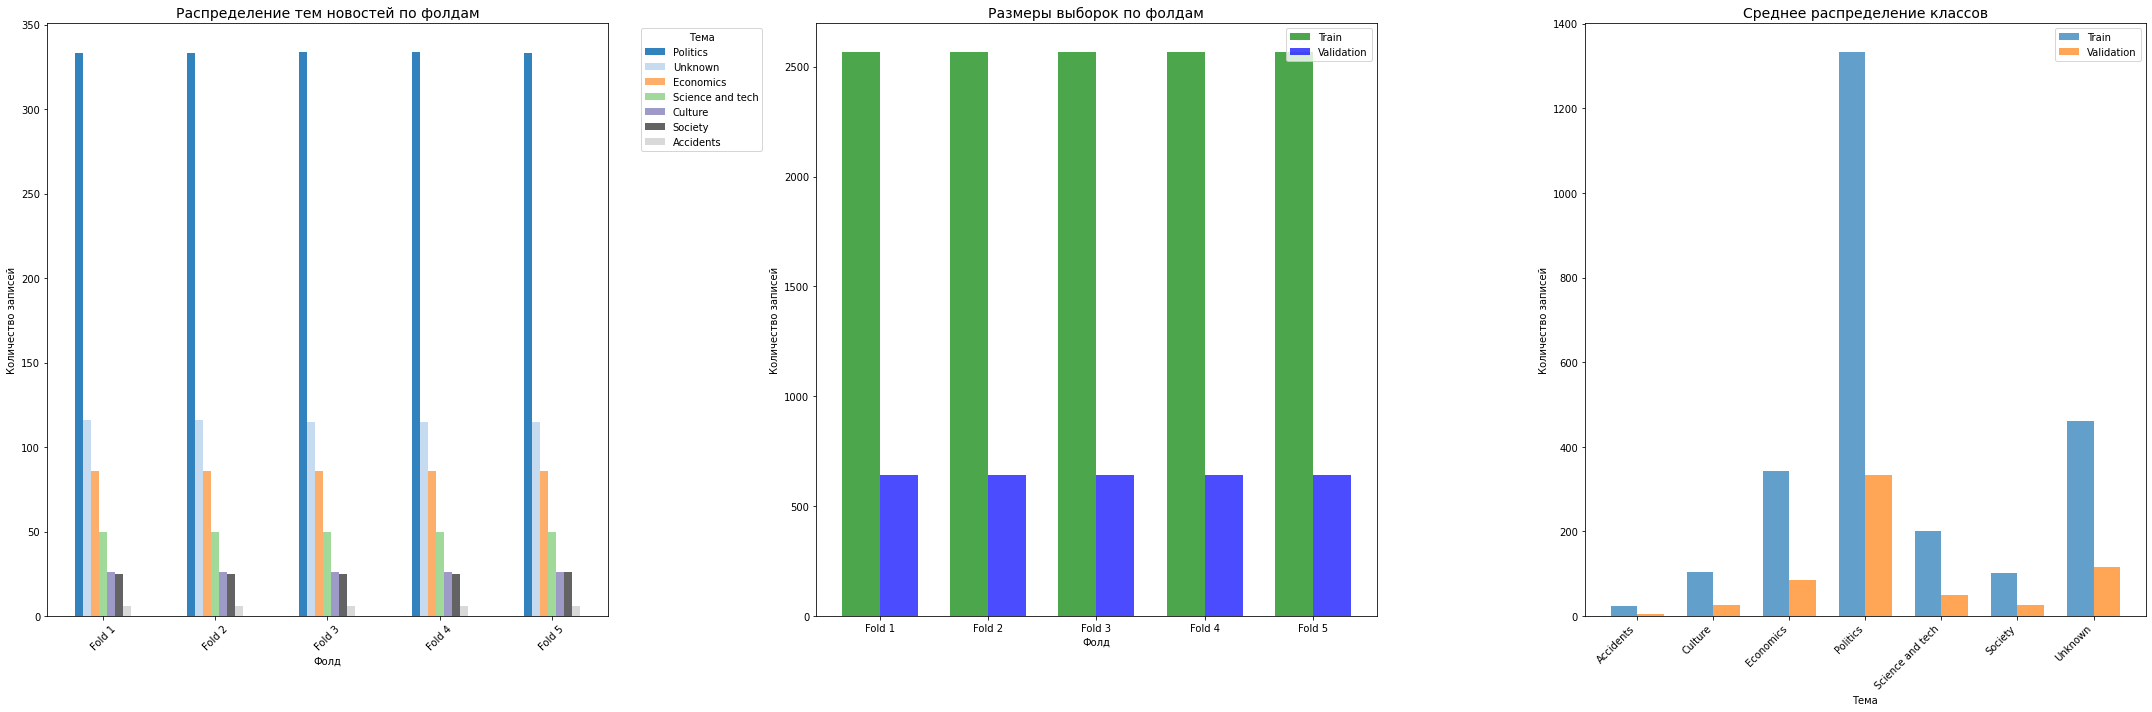

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

fold_data = []
for fold_info in fold_splits:
    val_classes = fold_info['val_classes']
    fold_data.append(val_classes)

fold_df = pd.DataFrame(fold_data, index=[f'Fold {i+1}' for i in range(n_splits)])
fold_df.columns = label_encoder.classes_



top_topics = fold_df.sum().nlargest(8).index
fold_df[top_topics].plot(kind='bar', ax=axes[0], colormap='tab20c')
axes[0].set_title('Распределение тем новостей по фолдам', fontsize=14)
axes[0].set_xlabel('Фолд')
axes[0].set_ylabel('Количество записей')
axes[0].legend(title='Тема', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)



train_sizes = [fold_info['train_size'] for fold_info in fold_splits]
val_sizes = [fold_info['val_size'] for fold_info in fold_splits]

x = np.arange(n_splits)
width = 0.35

axes[1].bar(x - width/2, train_sizes, width, label='Train', alpha=0.7, color='green')
axes[1].bar(x + width/2, val_sizes, width, label='Validation', alpha=0.7, color='blue')
axes[1].set_title('Размеры выборок по фолдам', fontsize=14)
axes[1].set_xlabel('Фолд')
axes[1].set_ylabel('Количество записей')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
axes[1].legend()



train_class_means = np.mean([fold_info['train_classes'] for fold_info in fold_splits], axis=0)
val_class_means = np.mean([fold_info['val_classes'] for fold_info in fold_splits], axis=0)

x_pos = np.arange(len(label_encoder.classes_))
width = 0.35

axes[2].bar(x_pos - width/2, train_class_means, width, label='Train', alpha=0.7)
axes[2].bar(x_pos + width/2, val_class_means, width, label='Validation', alpha=0.7)
axes[2].set_title('Среднее распределение классов', fontsize=14)
axes[2].set_xlabel('Тема')
axes[2].set_ylabel('Количество записей')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

### Поиск моделей для обучения и обучение

#### Проверка моделей классического машинного обучения

In [55]:
cv_results_acc = {}
cv_results_f1 = {}

def train_model(model_name, model):
    print(f"\nТестирование модели: {model_name}")
    try:
        cv_scores_acc = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        cv_results_acc[model_name] = {
            'mean_accuracy': cv_scores_acc.mean(),
            'std_accuracy': cv_scores_acc.std(),
            'scores': cv_scores_acc
        }
        cv_scores_f1 = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='f1_weighted', n_jobs=-1)
        cv_results_f1[model_name] = {
            'mean_f1': cv_scores_f1.mean(),
            'std_f1': cv_scores_f1.std(),
            'scores': cv_scores_f1
        }
        print(f"Средняя точность: {cv_scores_acc.mean():.3f} (+/- {cv_scores_acc.std():.3f})")
        print(f"Точность по фолдам: {cv_scores_acc}")
        print(f"Средний f1-score: {cv_scores_f1.mean():.3f} (+/- {cv_scores_f1.std():.3f})")
        print(f"F1-score по фолдам: {cv_scores_f1}")
        y_pred = cross_val_predict(model, X_vectorized, y_encoded, cv=skf, n_jobs=-1)
        target_names = label_encoder.classes_
        cm = confusion_matrix(y_encoded, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title(f'Матрица ошибок: {model_name}')
        plt.ylabel('Истинный класс')
        plt.xlabel('Предсказанный класс')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при обучении модели: {e}")
        cv_results_acc[model_name] = None
        cv_results_f1[model_name] = None


Тестирование модели: LogisticRegression
Средняя точность: 0.616 (+/- 0.024)
Точность по фолдам: [0.65264798 0.63084112 0.59345794 0.58878505 0.6152648 ]
Средний f1-score: 0.628 (+/- 0.020)
F1-score по фолдам: [0.65953134 0.64163066 0.61078116 0.60523955 0.62478888]


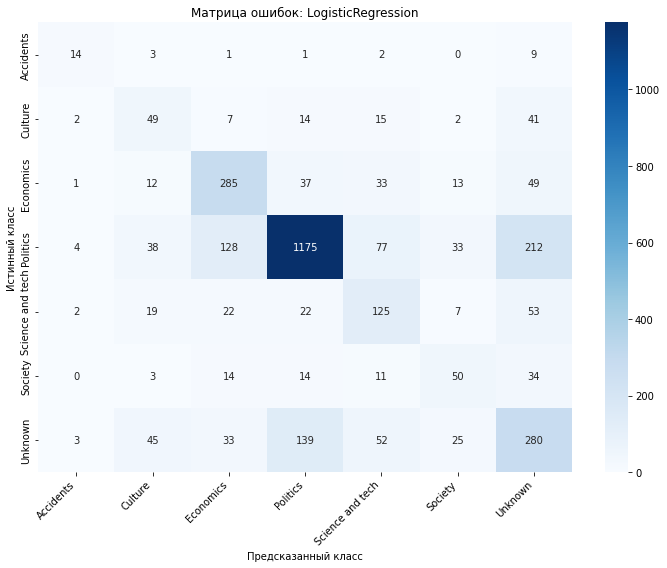


Тестирование модели: SVC
Средняя точность: 0.612 (+/- 0.022)
Точность по фолдам: [0.63707165 0.63551402 0.59501558 0.58099688 0.6105919 ]
Средний f1-score: 0.625 (+/- 0.020)
F1-score по фолдам: [0.64713684 0.64723034 0.60974852 0.5986935  0.62182661]


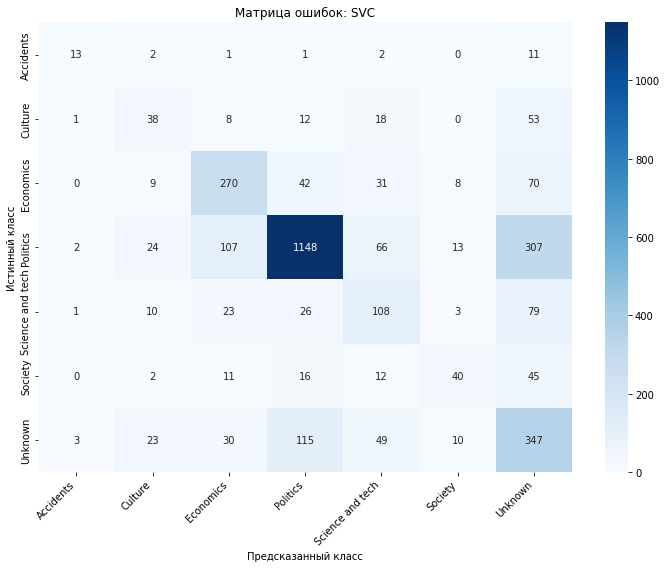


Тестирование модели: RandomForest
Средняя точность: 0.617 (+/- 0.012)
Точность по фолдам: [0.64018692 0.60747664 0.61370717 0.6105919  0.61370717]
Средний f1-score: 0.619 (+/- 0.011)
F1-score по фолдам: [0.63743736 0.6219932  0.61899711 0.60873151 0.60546907]


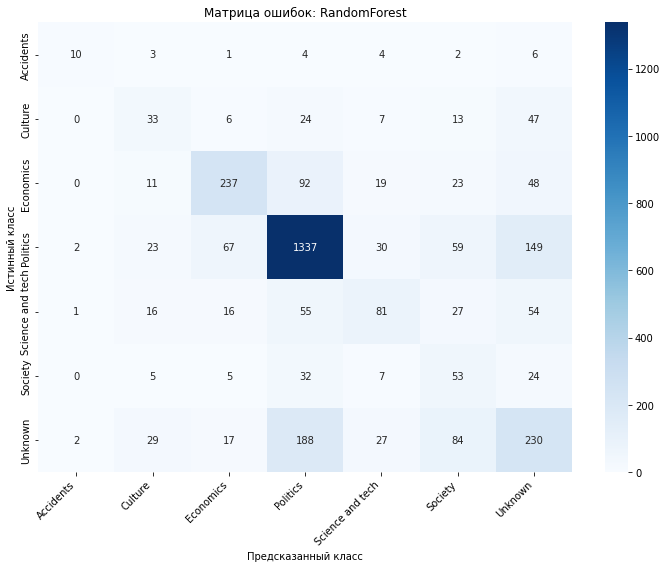


Тестирование модели: MultinomialNB
Средняя точность: 0.560 (+/- 0.009)
Точность по фолдам: [0.5529595  0.57165109 0.5623053  0.56697819 0.5482866 ]
Средний f1-score: 0.456 (+/- 0.016)
F1-score по фолдам: [0.44351054 0.48166313 0.45108745 0.46383548 0.43844039]


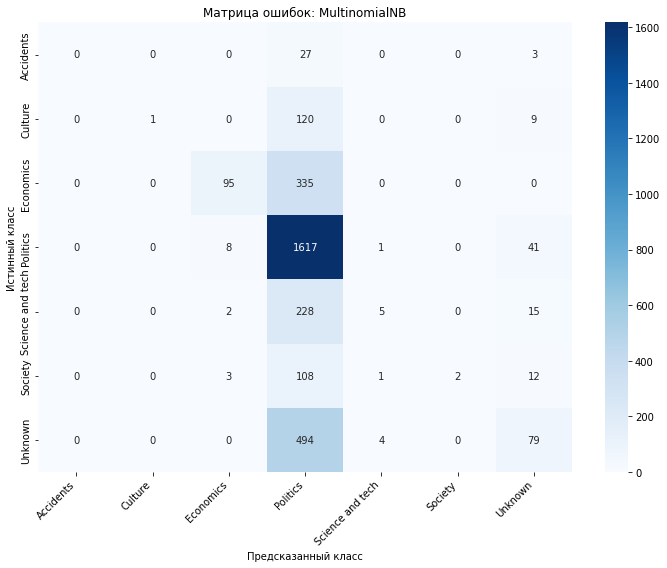

In [56]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=100000, class_weight='balanced', random_state=42, n_jobs=-1),
    'SVC': SVC(kernel='linear', class_weight='balanced', random_state=42, max_iter=100000),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1, verbose=0),
    'MultinomialNB': MultinomialNB(),
}

for model_name, model in models.items():
    train_model(model_name=model_name, model=model)

Судя по выведенным метрикам, наилучшей моделью классического машинного обучения для нашего датасета является случайный лес (при заданных параметрах).
Можно заметить, что accuracy оказалась довольно низкой, такие результаты могут оказаться из-за множественной классификации, а также из-за частично перекрывающихся тем (один и тот же заголовок может быть отнесён к нескольким темам сразу)

В итоге для обучения выбираем случайный лес (только нам надо его немного модифицировать, чтобы повысить accuracy и другие метрики)


Тестирование модели: OneVsRestRandomForest
Средняя точность: 0.631 (+/- 0.023)
Точность по фолдам: [0.6635514  0.64797508 0.60124611 0.60903427 0.63084112]
Средний f1-score: 0.637 (+/- 0.020)
F1-score по фолдам: [0.66579387 0.65392701 0.61580017 0.61675737 0.63488131]


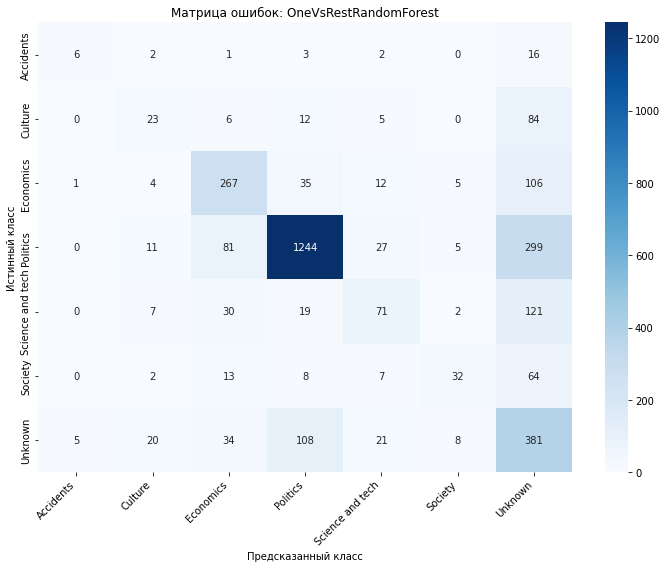

In [57]:
rf_params = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'class_weight': 'balanced_subsample',
    'n_jobs': -1,
    'random_state': 42
}

ovr_model = OneVsRestClassifier(RandomForestClassifier(**rf_params))
train_model(model_name='OneVsRestRandomForest', model=ovr_model)

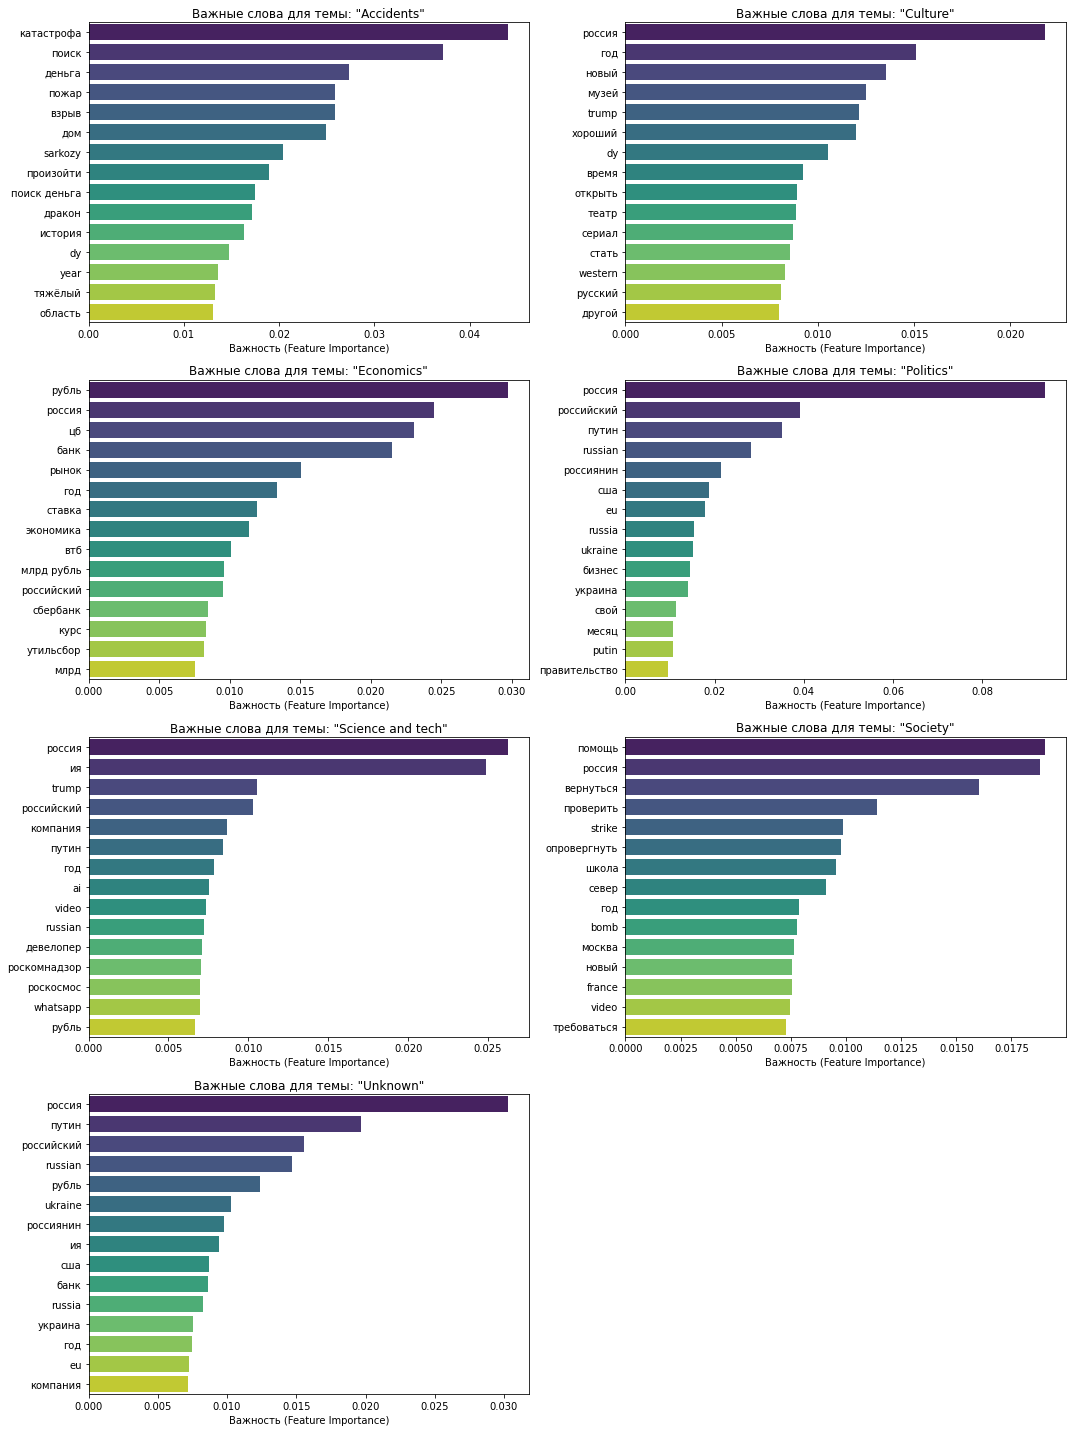

In [59]:
def plot_ovr_feature_importances(model, vectorizer, label_encoder, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    classes = label_encoder.classes_
    n_classes = len(classes)
    n_cols = 2
    n_rows = (n_classes + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for idx, estimator in enumerate(model.estimators_):
        class_name = classes[idx]
        importances = estimator.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]
        ax = axes[idx]
        sns.barplot(x=top_importances, y=top_features, ax=ax, palette='viridis', hue=top_features, legend=False)
        ax.set_title(f'Важные слова для темы: "{class_name}"')
        ax.set_xlabel('Важность (Feature Importance)')
    
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

ovr_model.fit(X_vectorized, y_encoded)
plot_ovr_feature_importances(ovr_model, vectorizer, label_encoder, top_n=15)

In [60]:
test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Учёные создали прототип 70-кубитного квантового компьютера",
    "Курс доллара достиг исторического максимума на бирже",
    "Зеленский: мирный план США не требует отказа Украины от курса на НАТО",
    "Пожар в доме унес жизни трех человек"
]

ovr_model.fit(X_vectorized, y_encoded)

print("Примеры предсказаний:")
for title in test_examples:
    processed = preprocess_text(title)
    vectorized = vectorizer.transform([processed])
    prediction_encoded = ovr_model.predict(vectorized)[0]
    prediction_label = label_encoder.inverse_transform([prediction_encoded])[0]
    print(f"'{title}' -> {prediction_label}")

Примеры предсказаний:
'Новые санкции США против России вступили в силу сегодня' -> Politics
'Футбольный матч закончился со счетом 2:1 в пользу домашней команды' -> Unknown
'Учёные создали прототип 70-кубитного квантового компьютера' -> Unknown
'Курс доллара достиг исторического максимума на бирже' -> Economics
'Зеленский: мирный план США не требует отказа Украины от курса на НАТО' -> Politics
'Пожар в доме унес жизни трех человек' -> Accidents


### Проверка нейронных сетей

#### Подготовка датасета и классификатора

In [61]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

In [62]:
class BertClassifier(nn.Module):
    def __init__(self, output_dim, model_name):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        self.bert_hidden_dim = self.bert.config.hidden_size
        
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert_hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        output = self.drop(pooled_output)
        return self.out(output)

In [63]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

train_x, val_x, train_y, val_y = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

MODEL_NAME = 'cointegrated/rubert-tiny2'
MAX_LEN = 64
BATCH_SIZE = 32
LR = 0.0005
NUM_EPOCHS = 10

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = BertDataset(train_x, train_y, tokenizer, MAX_LEN)
val_dataset = BertDataset(val_x, val_y, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = BertClassifier(OUTPUT_DIM, MODEL_NAME).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

Используется устройство: cuda
GPU: NVIDIA GeForce GTX 1660 Ti


2025-12-28 20:56:28.388710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Подготовка нейронной сети BERT (Bidirectional Encoder Representations from Transformers)

In [64]:
train_losses = []
val_losses = []
val_acc_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        _, preds = torch.max(outputs, dim=1)
        correct_train += torch.sum(preds == targets)
        total_train += targets.size(0)
        
    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_train.double() / total_train
    train_losses.append(avg_train_loss)



    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, dim=1)
            correct_val += torch.sum(preds == targets)
            total_val += targets.size(0)
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val.double() / total_val
    val_losses.append(avg_val_loss)
    val_acc_history.append(val_acc.item() * 100)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 1.1929 | Val Loss: 1.0091 | Val Acc: 0.6179
Epoch 2/10 | Train Loss: 0.6608 | Val Loss: 1.0012 | Val Acc: 0.6916
Epoch 3/10 | Train Loss: 0.2927 | Val Loss: 1.2828 | Val Acc: 0.6656
Epoch 4/10 | Train Loss: 0.1562 | Val Loss: 1.5969 | Val Acc: 0.6822
Epoch 5/10 | Train Loss: 0.0802 | Val Loss: 1.8662 | Val Acc: 0.6407
Epoch 6/10 | Train Loss: 0.0643 | Val Loss: 1.8880 | Val Acc: 0.6874
Epoch 7/10 | Train Loss: 0.0453 | Val Loss: 1.8965 | Val Acc: 0.6698
Epoch 8/10 | Train Loss: 0.0426 | Val Loss: 1.9968 | Val Acc: 0.6729
Epoch 9/10 | Train Loss: 0.0372 | Val Loss: 1.9619 | Val Acc: 0.6781
Epoch 10/10 | Train Loss: 0.0364 | Val Loss: 2.0105 | Val Acc: 0.6771


#### Проверка на новых заголовках

In [68]:
def predict_text(text, model, tokenizer, label_encoder, max_len=MAX_LEN):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits
            
        probabilities = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probabilities, dim=1).item()
    
    predicted_class = label_encoder.classes_[pred_idx]
    confidence = probabilities[0][pred_idx].item()

    class_probabilities = {}
    for idx, class_name in enumerate(label_encoder.classes_):
        prob = probabilities[0][idx].item()
        class_probabilities[class_name] = prob
    
    return predicted_class, confidence, class_probabilities

test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Учёные создали прототип 70-кубитного квантового компьютера",
    "Зеленский: мирный план США не требует отказа Украины от курса на НАТО",
    "Курс доллара достиг исторического максимума на бирже",
    "Пожар в доме унес жизни трех человек"
]

print("Примеры предсказаний:")
for example in test_examples:
    predicted, confidence, probabilities = predict_text(example, model, tokenizer, label_encoder)
    print(f"\n{example}")
    print(f"Предсказанная тема: {predicted} (confidence: {confidence:.3f})")

Примеры предсказаний:

Новые санкции США против России вступили в силу сегодня
Предсказанная тема: Politics (confidence: 1.000)

Футбольный матч закончился со счетом 2:1 в пользу домашней команды
Предсказанная тема: Unknown (confidence: 0.632)

Учёные создали прототип 70-кубитного квантового компьютера
Предсказанная тема: Science and tech (confidence: 0.601)

Зеленский: мирный план США не требует отказа Украины от курса на НАТО
Предсказанная тема: Politics (confidence: 1.000)

Курс доллара достиг исторического максимума на бирже
Предсказанная тема: Economics (confidence: 0.998)

Пожар в доме унес жизни трех человек
Предсказанная тема: Accidents (confidence: 0.633)


Как мы видим, обученная языковая модель классифицирует заголовки по темам чуть лучше, чем классические модели (accuracy составляет около 67%)